# Bitcoin

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


#### Preprocessing Steps

In [179]:
# bitcoin = pd.read_csv('bitcoin_original.csv')
# bitcoin = bitcoin.drop(columns=['Unnamed: 0'])
# for name in bitcoin.columns[1:-2]:
#     bitcoin[name] = bitcoin[name].str.replace(',', '').astype(float)
# bitcoin['Date'] = pd.to_datetime(bitcoin['Date'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
# bitcoin = bitcoin.sort_values('Date')
# bitcoin['Average'] = (bitcoin['High'] + bitcoin['Low']) / 2
# bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
# bitcoin.head()

In [180]:
bitcoin_data = pd.read_csv('data/bitcoin/bitcoin_preprocessed.csv', parse_dates=['Date'])

In [181]:
bitcoin_data.head()

,Date,Price,Open,High,Low,Vol.,Change %,Average
0,2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%,0.1
1,2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%,0.1
2,2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,0.1
3,2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,0.1
4,2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,0.1


In [182]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5282 non-null   datetime64[ns]
 1   Price     5282 non-null   float64       
 2   Open      5282 non-null   float64       
 3   High      5282 non-null   float64       
 4   Low       5282 non-null   float64       
 5   Vol.      5276 non-null   object        
 6   Change %  5282 non-null   object        
 7   Average   5282 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 330.3+ KB


In [183]:
bitcoin_data.describe()

,Date,Price,Open,High,Low,Average
count,5282,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,2017-10-09 12:00:00,13991.793601,13973.960621,14301.911473,13630.541746,13966.226609
min,2010-07-18 00:00:00,0.100000,0.000000,0.100000,0.000000,0.050000
25%,2014-02-27 06:00:00,236.325000,236.225000,240.300000,232.325000,236.250000
50%,2017-10-09 12:00:00,3694.250000,3688.400000,3826.400000,3611.800000,3727.825000
75%,2021-05-21 18:00:00,20759.675000,20725.975000,21307.025000,20256.025000,20796.437500
max,2025-01-01 00:00:00,106138.900000,106140.700000,108244.900000,105350.600000,106797.750000
std,NaN,20663.596560,20634.796513,21096.208461,20162.686270,20626.123003


In [184]:
bitcoin_data.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        6
Change %    0
Average     0
dtype: int64

Calculating Simple Moving Average

In [185]:
bitcoin_data.head()

,Date,Price,Open,High,Low,Vol.,Change %,Average
0,2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%,0.1
1,2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%,0.1
2,2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,0.1
3,2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,0.1
4,2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,0.1


In [186]:
bitcoin_data['SMA_weekly'] = bitcoin_data['Price'].rolling(window=7).mean()

bitcoin_data.head(15)

,Date,Price,Open,High,Low,Vol.,Change %,Average,SMA_weekly
0,2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%,0.1,NaN
1,2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%,0.1,NaN
2,2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,0.1,NaN
3,2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,0.1,NaN
4,2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,0.1,NaN
5,2010-07-23,0.1,0.1,0.1,0.1,2.40K,0.00%,0.1,NaN
6,2010-07-24,0.1,0.1,0.1,0.1,0.50K,0.00%,0.1,0.1
7,2010-07-25,0.1,0.1,0.1,0.1,1.55K,0.00%,0.1,0.1
8,2010-07-26,0.1,0.1,0.1,0.1,0.88K,0.00%,0.1,0.1
9,2010-07-27,0.1,0.1,0.1,0.1,3.37K,0.00%,0.1,0.1


In [187]:
bitcoin_data.tail()

,Date,Price,Open,High,Low,Vol.,Change %,Average,SMA_weekly
5277,2024-12-28,95284.5,94274.9,95684.3,94124.7,32.97K,1.07%,94904.50,96204.771429
5278,2024-12-29,93716.3,95282.6,95315.4,93026.7,47.71K,-1.65%,94171.05,95995.128571
5279,2024-12-30,92779.8,93718.7,94936.4,91522.3,112.43K,-1.00%,93229.35,95699.085714
5280,2024-12-31,93557.2,92777.2,96163.4,92036.2,74.85K,0.84%,94099.80,94968.957143
5281,2025-01-01,94560.2,93557.3,95100.0,92939.3,43.34K,1.07%,94019.65,94278.800000


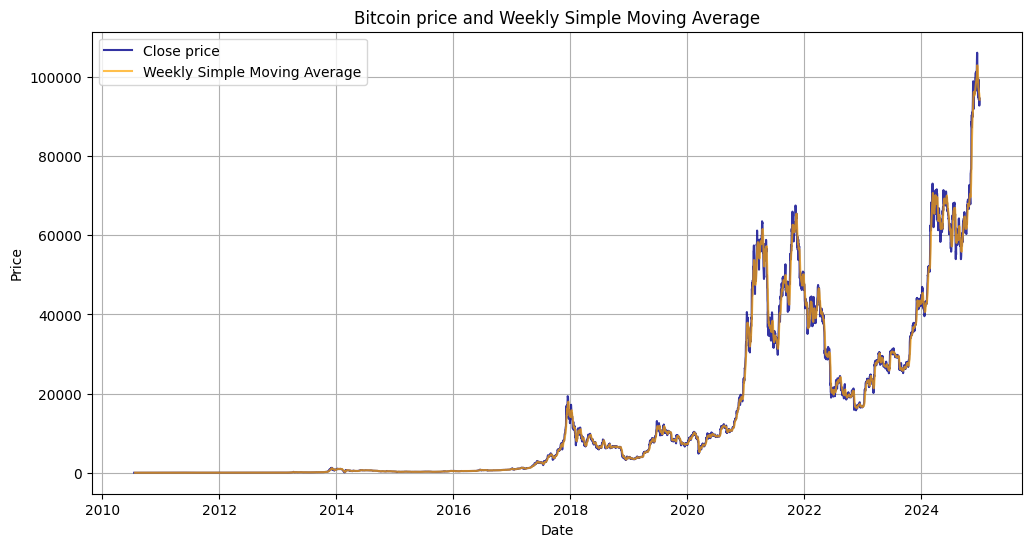

In [188]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data["Date"], bitcoin_data["Price"], label='Close price', color='darkblue', alpha=0.8)
plt.plot(bitcoin_data["Date"], bitcoin_data['SMA_weekly'], label='Weekly Simple Moving Average', color='orange', alpha=0.7)
plt.title('Bitcoin price and Weekly Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

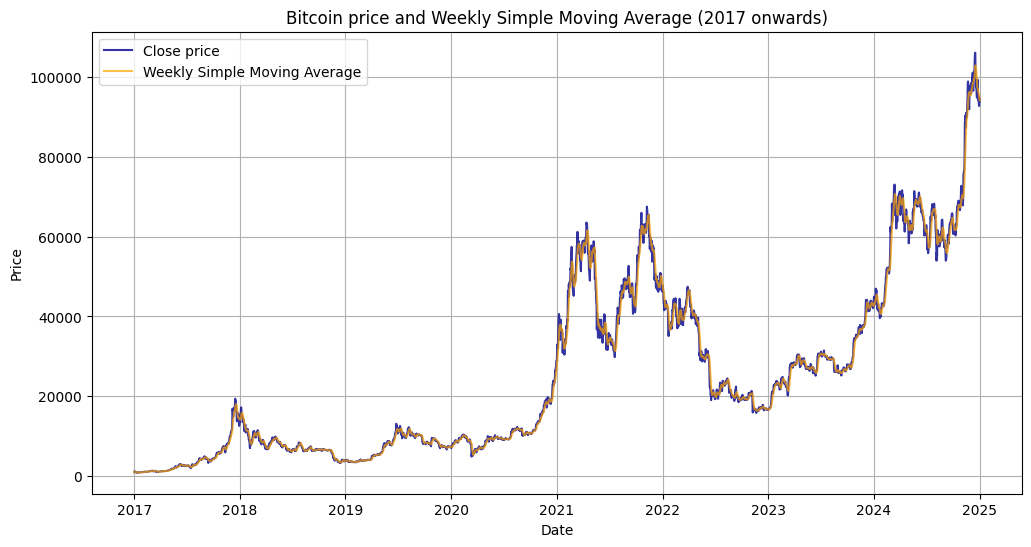

In [189]:
bitcoin_data_filtered = bitcoin_data[bitcoin_data['Date'] >= '2017-01-01']
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data_filtered["Date"], bitcoin_data_filtered["Price"], label='Close price', color='darkblue', alpha=0.8)
plt.plot(bitcoin_data_filtered["Date"], bitcoin_data_filtered['SMA_weekly'], label='Weekly Simple Moving Average', color='orange', alpha=0.7)
plt.title('Bitcoin price and Weekly Simple Moving Average (2017 onwards)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#### Graphing Bitcoin Halving events

When Is the Next Bitcoin Halving?

Nov. 28, 2012, to 25 bitcoins.

July 9, 2016, to 12.5 bitcoins.

May 11, 2020, to 6.25 bitcoins.

April 19, 2024, to 3.125 bitcoins.

<figure>
  <img src="data/bitcoin/bitcoin_halving.webp" alt="Bitcoin Halving" width="600">
  <figcaption>Source: [Bitcoin Halving: What It Is and Why It Matters for Crypto Investors](https://www.investopedia.com/bitcoin-halving-4843769)</figcaption>
</figure>


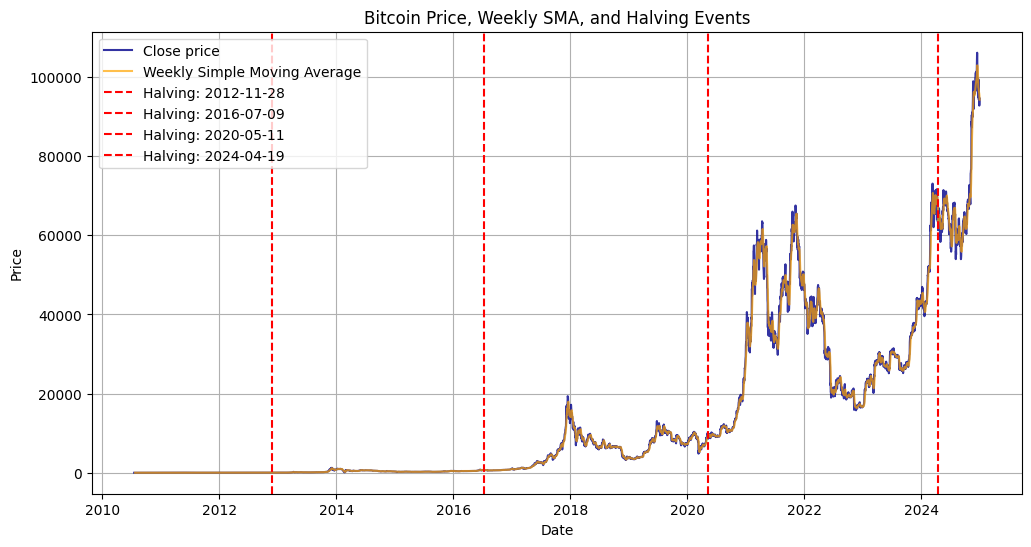

In [190]:
halving_dates = pd.to_datetime(['2012-11-28', '2016-07-09', '2020-05-11', '2024-04-19'])
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_data["Date"], bitcoin_data["Price"], label='Close price', color='darkblue', alpha=0.8)
plt.plot(bitcoin_data["Date"], bitcoin_data['SMA_weekly'], label='Weekly Simple Moving Average', color='orange', alpha=0.7)

for halving_date in halving_dates:
    plt.axvline(x=halving_date, color='red', linestyle='--', label=f'Halving: {halving_date.strftime("%Y-%m-%d")}')
plt.title('Bitcoin Price, Weekly SMA, and Halving Events')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

---

### Here we change the dataset slightly, by dropping some columns that we were not using for clarity

#### Dropping columns

In [191]:
bitcoin_data.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Average',
       'SMA_weekly'],
      dtype='object')

In [192]:
columns_to_drop = ['Open', 'High', 'Low', 'Vol.', 'Change %', 'Average']

bitcoin = bitcoin_data[bitcoin_data['Date'] >= '2017-01-01']
bitcoin = bitcoin.drop(columns=columns_to_drop)
bitcoin

,Date,Price,SMA_weekly
2359,2017-01-01,995.4,955.042857
2360,2017-01-02,1017.0,971.985714
2361,2017-01-03,1033.3,987.342857
2362,2017-01-04,1135.4,1010.657143
2363,2017-01-05,989.3,1013.257143
...,...,...,...
5277,2024-12-28,95284.5,96204.771429
5278,2024-12-29,93716.3,95995.128571
5279,2024-12-30,92779.8,95699.085714
5280,2024-12-31,93557.2,94968.957143


#### Stationarity check - Augmented Dickey–Fuller test and stationarity checks

In [193]:
adf_test = adfuller(bitcoin['Price'])
print("ADF statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical values:", adf_test[4])

if adf_test[1] < 0.05:
    print("Reject the null hypothesis - series is stationary")
else:
    print("Fail to reject the null hypothesis - series is non-stationary")

ADF statistic: -0.3550941310181112
p-value: 0.9173307895600109
Critical values: {'1%': np.float64(-3.432611613600796), '5%': np.float64(-2.862539228682693), '10%': np.float64(-2.5673019179781917)}
Fail to reject the null hypothesis - series is non-stationary


In [194]:
bitcoin['Close_Diff'] = bitcoin['Price'].diff()  # Difference of close prices
bitcoin['Close_Log'] = np.log(bitcoin['Price'])  # Log of close prices
bitcoin['Close_Log_Diff'] = bitcoin['Close_Log'].diff()  # Difference of Log of close prices

In [195]:
bitcoin.head()

,Date,Price,SMA_weekly,Close_Diff,Close_Log,Close_Log_Diff
2359,2017-01-01,995.4,955.042857,NaN,6.903145,NaN
2360,2017-01-02,1017.0,971.985714,21.6,6.924612,0.021468
2361,2017-01-03,1033.3,987.342857,16.3,6.940513,0.015900
2362,2017-01-04,1135.4,1010.657143,102.1,7.034740,0.094227
2363,2017-01-05,989.3,1013.257143,-146.1,6.896998,-0.137743


Drop the NaN values created by differencing

In [196]:
bitcoin.dropna(subset=['Close_Diff', 'Close_Log', 'Close_Log_Diff'], inplace=True)
bitcoin.head()

,Date,Price,SMA_weekly,Close_Diff,Close_Log,Close_Log_Diff
2360,2017-01-02,1017.0,971.985714,21.6,6.924612,0.021468
2361,2017-01-03,1033.3,987.342857,16.3,6.940513,0.015900
2362,2017-01-04,1135.4,1010.657143,102.1,7.034740,0.094227
2363,2017-01-05,989.3,1013.257143,-146.1,6.896998,-0.137743
2364,2017-01-06,886.2,1002.857143,-103.1,6.786943,-0.110055


In [197]:
bitcoin.tail()

,Date,Price,SMA_weekly,Close_Diff,Close_Log,Close_Log_Diff
5277,2024-12-28,95284.5,96204.771429,1008.6,11.464622,0.010642
5278,2024-12-29,93716.3,95995.128571,-1568.2,11.448027,-0.016595
5279,2024-12-30,92779.8,95699.085714,-936.5,11.437984,-0.010043
5280,2024-12-31,93557.2,94968.957143,777.4,11.446328,0.008344
5281,2025-01-01,94560.2,94278.800000,1003.0,11.456992,0.010664


In [198]:
from statsmodels.tsa.stattools import adfuller

series_list = {
    'Close_Diff': bitcoin['Close_Diff'],
    'Close_Log': bitcoin['Close_Log'],
    'Close_Log_Diff': bitcoin['Close_Log_Diff']
}

for label, series in series_list.items():
    adf_test = adfuller(series)
    adf_p_value = adf_test[1]
    if adf_p_value < 0.05:
        print(f"{label} is stationary, with p-value: {adf_p_value}")
    else:
        print(f"{label} is non-stationary, with p-value: {adf_p_value}")

Close_Diff is stationary, with p-value: 5.092059976116668e-14
Close_Log is non-stationary, with p-value: 0.421378570513697
Close_Log_Diff is stationary, with p-value: 0.0


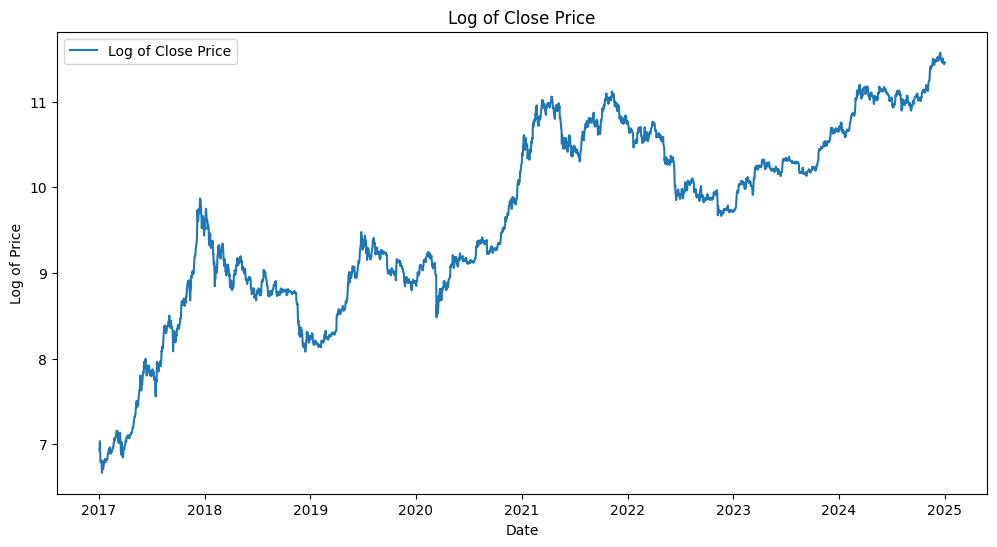

In [213]:
plt.figure(figsize=(12, 6))
plt.plot(bitcoin['Close_Log'], label='Log of Close Price')
plt.title('Log of Close Price')
plt.xlabel('Date')
plt.ylabel('Log of Price')
plt.legend()
plt.show()

In [202]:
def plot_decomposition(series, model, title):
    decomposition = seasonal_decompose(series, model=model, period=365)
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.suptitle(title, fontsize=16)
    plt.show()

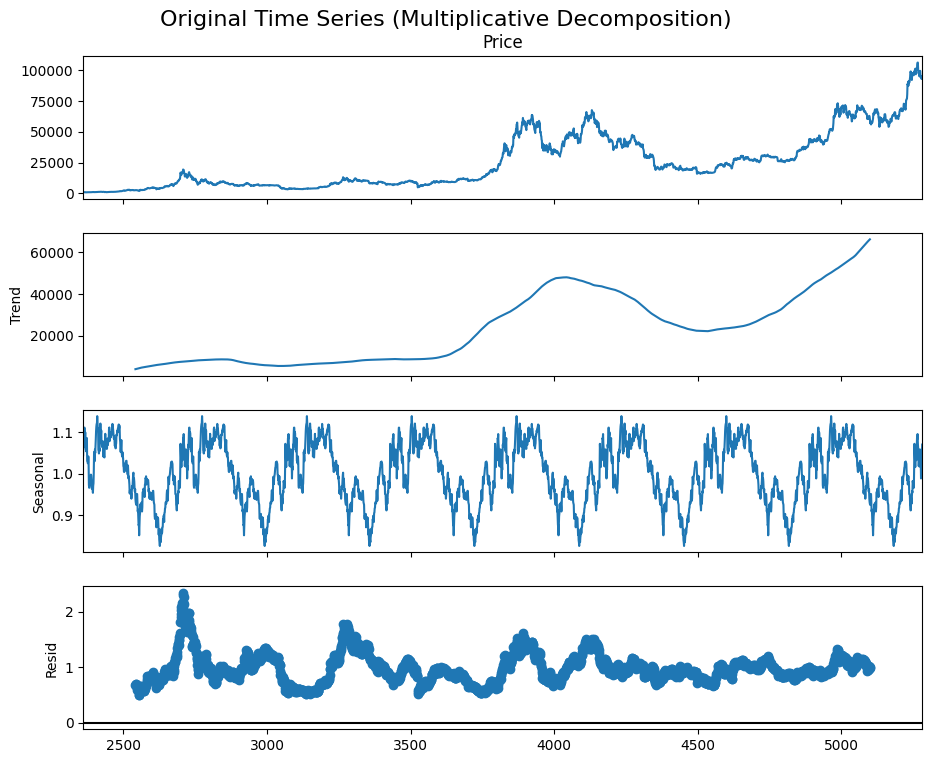

In [203]:
plot_decomposition(bitcoin['Price'], model='multiplicative', title="Original Time Series (Multiplicative Decomposition)")


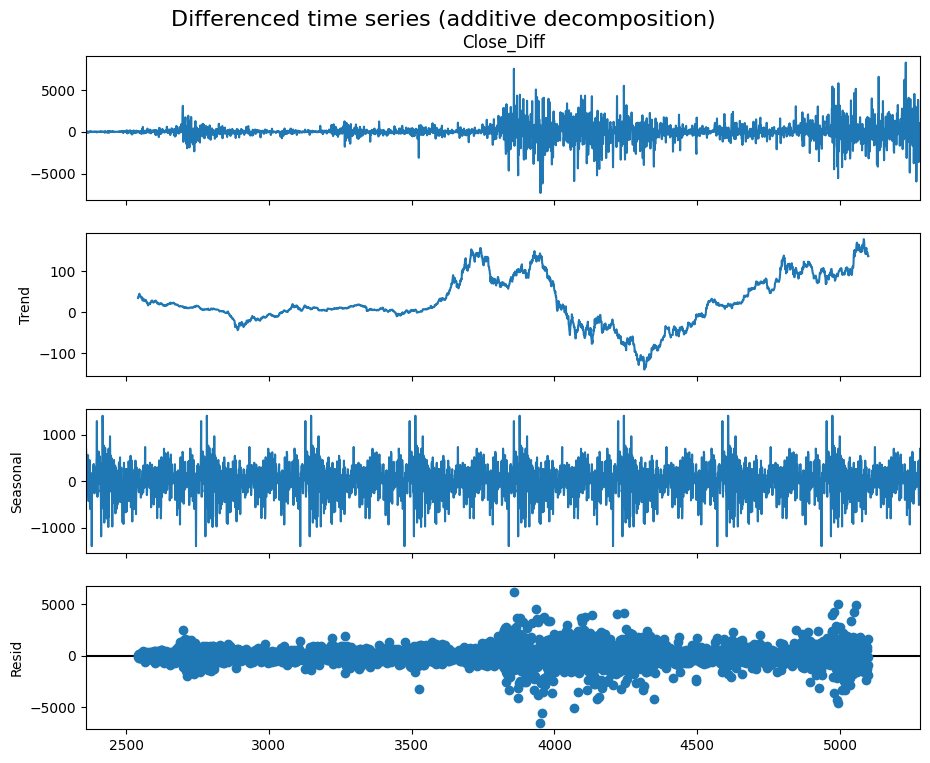

In [204]:
plot_decomposition(bitcoin['Close_Diff'], model='additive', title="Differenced time series (additive decomposition)")


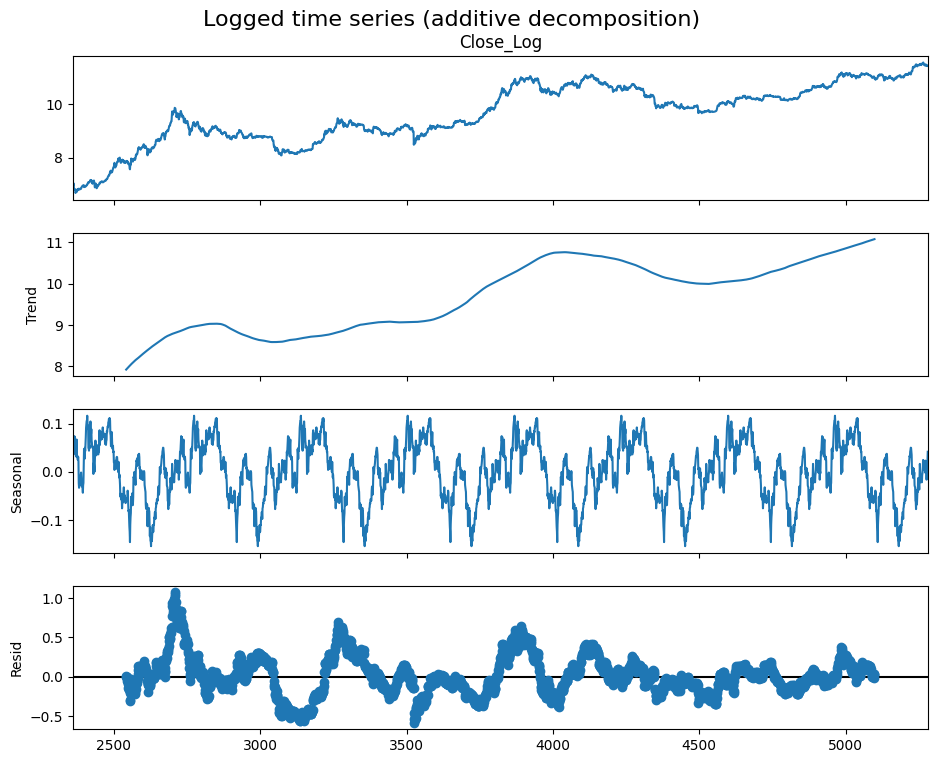

In [205]:
plot_decomposition(bitcoin['Close_Log'], model='additive', title="Logged time series (additive decomposition)")


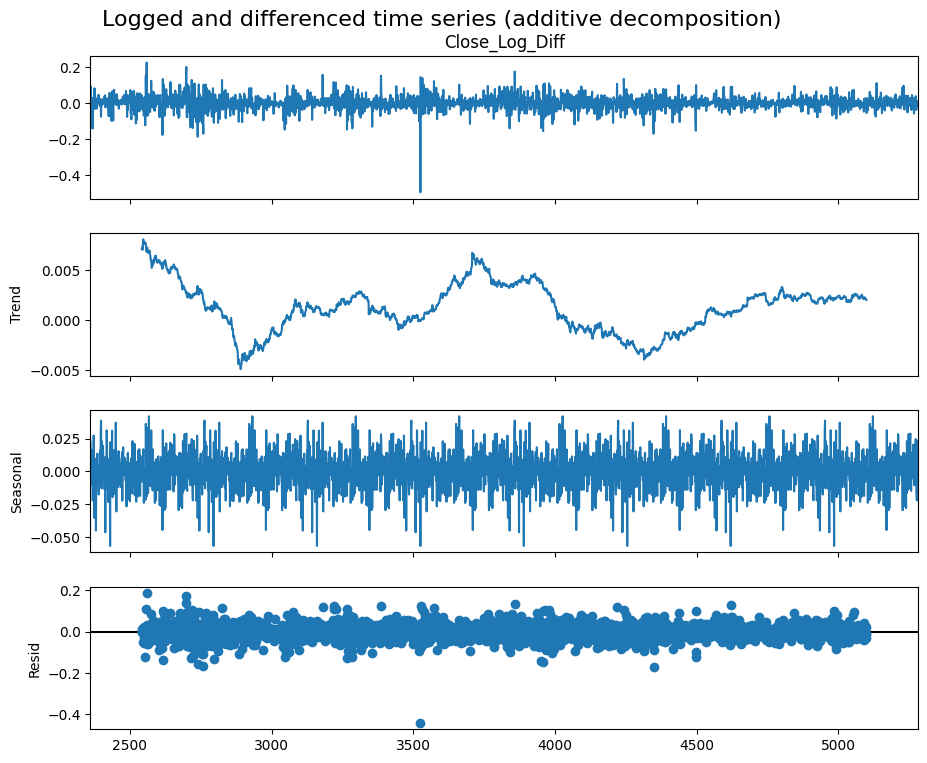

In [206]:
plot_decomposition(bitcoin['Close_Log_Diff'], model='additive', title="Logged and differenced time series (additive decomposition)")


Visualizing the prediction accuracy by the volume data available. The more data, the more precise the trend line is.

In [214]:
df_monthly = bitcoin.resample('ME').mean()
df_annual = bitcoin.resample('YE').mean()
df_quarterly = bitcoin.resample('QE').mean()


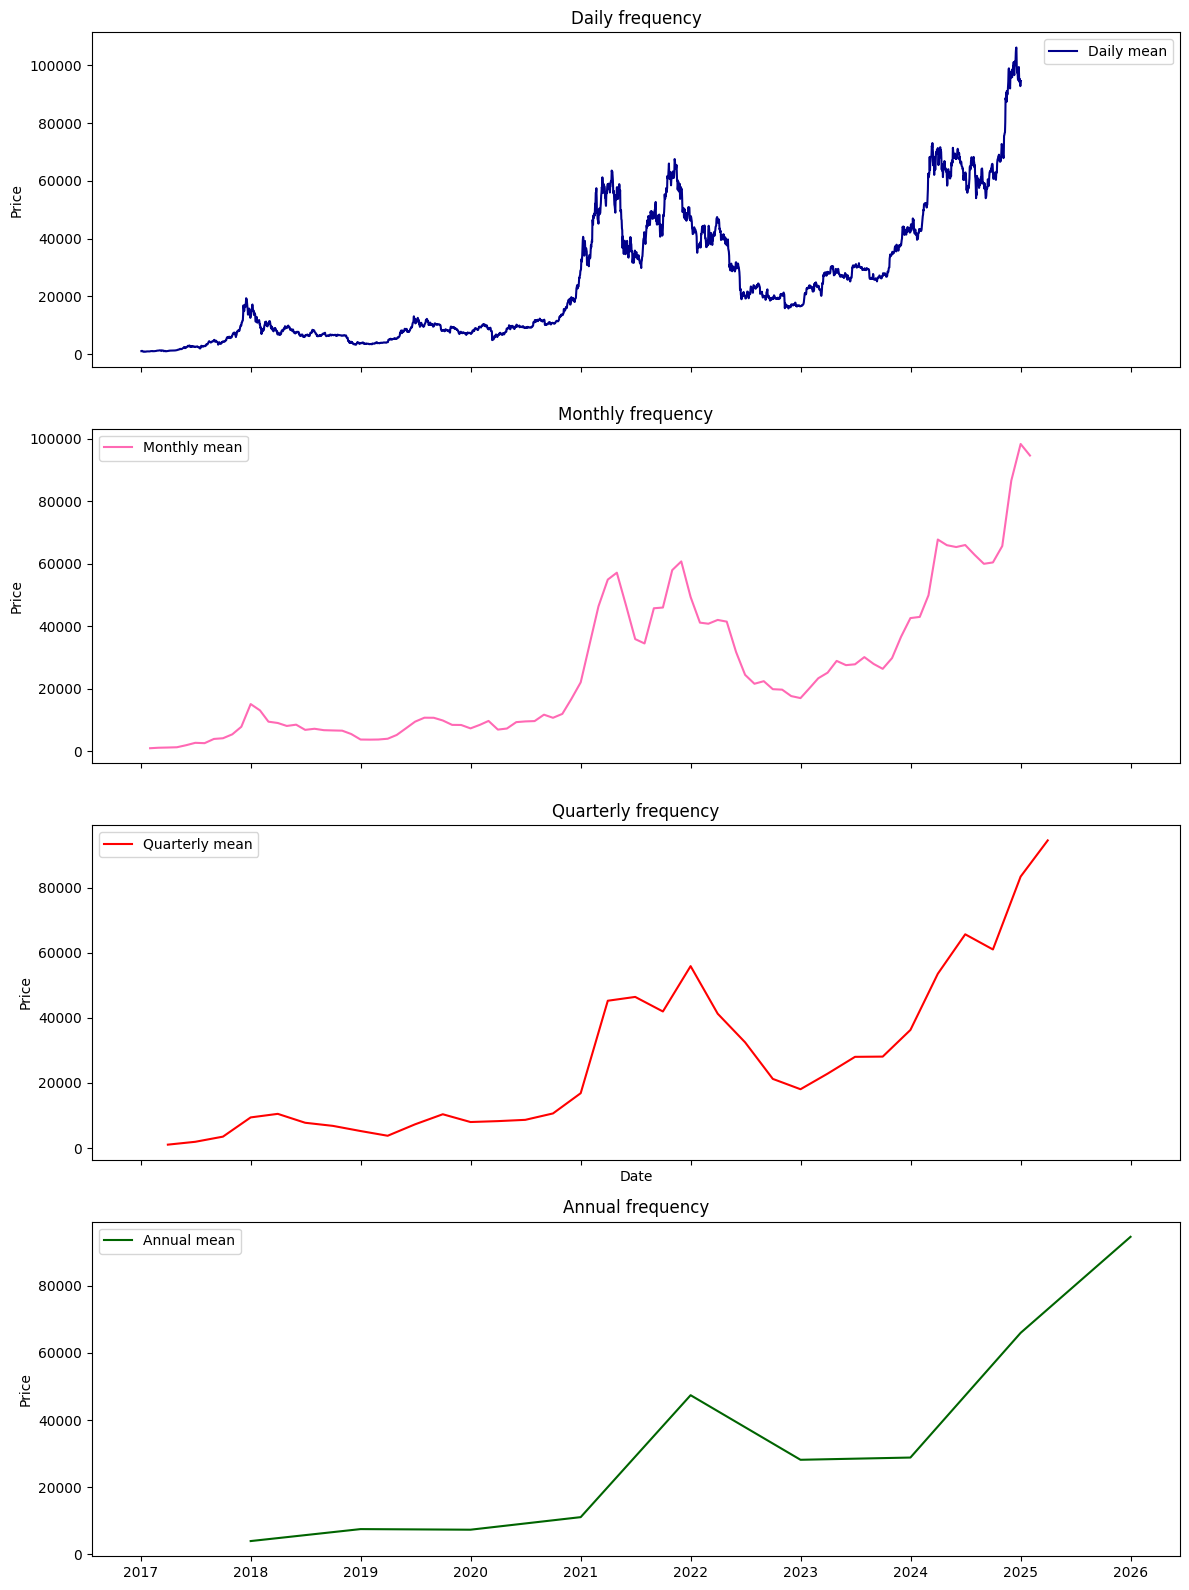

In [215]:
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
axs[0].plot(bitcoin.index, bitcoin['Price'], label='Daily mean', color='darkblue')
axs[0].set_title('Daily frequency')
axs[0].set_ylabel('Price')
axs[0].legend()

axs[1].plot(df_monthly.index, df_monthly['Price'], label='Monthly mean', color='hotpink')
axs[1].set_title('Monthly frequency')
axs[1].set_ylabel('Price')
axs[1].legend()

axs[2].plot(df_quarterly.index, df_quarterly['Price'], label='Quarterly mean', color='red')
axs[2].set_title('Quarterly frequency')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price')
axs[2].legend()

axs[3].plot(df_annual.index, df_annual['Price'], label='Annual mean', color='darkgreen')
axs[3].set_title('Annual frequency')
axs[3].set_ylabel('Price')
axs[3].legend()

plt.tight_layout()
plt.show()

Yearly seasonality

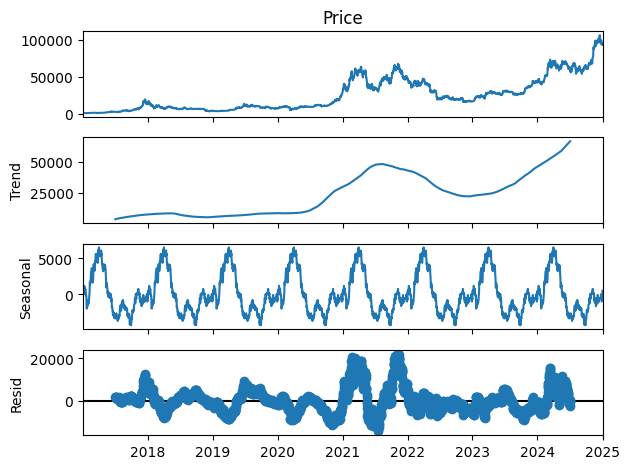

In [216]:
decomposition = seasonal_decompose(bitcoin['Price'], model='additive', period=365)
decomposition.plot()
plt.show()


Plot ACF and PACF

<Figure size 1200x600 with 0 Axes>

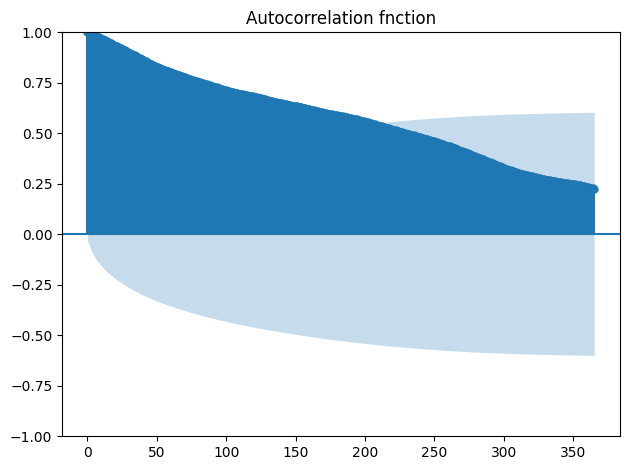

In [217]:
plt.figure(figsize=(12, 6))
plot_acf(bitcoin['Price'], lags=365)
plt.title("Autocorrelation fnction")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

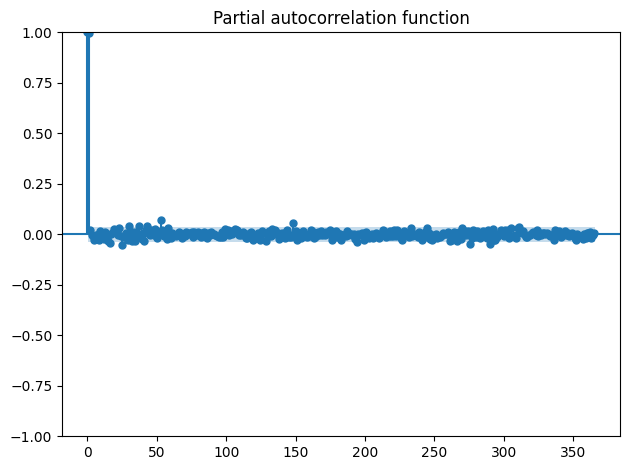

In [218]:
plt.figure(figsize=(12, 6))
plot_pacf(bitcoin['Price'], lags=365)
plt.title("Partial autocorrelation function")
plt.tight_layout()
plt.show()